# Introduction
Regression on Taxi Trip Duration
NYC Taxi Dataset

Steps:
1. Load requirements
2. Build Simple Models
    1. Mean prediction - Baseline
    2. Distance, time columns only - Simplest, intuitive model
    3. Add more information and inspect performance
    4. Build a model with all columns
3. Improve Best performaing model from above
    1. Feature selection
    2. Hyperparameter Tuning
4. Conclusions, Ideas for further improvement

Dependencies:
 - data_preprocessing_helpers : functions to preprocess data and return DFs ready for modelling
 - modelling_helpers : functions to build and evaluate models


In [2]:
%load_ext autoreload
%autoreload 2
#"notebook.output.textLineLimit": 500
#!unzip ./data/nyc_taxi_final.zip
#!unzip ./data/osrm/fastest_routes_train_part_1.zip
#!unzip ./data/osrm/fastest_routes_train_part_2.zip 

# Load
## Packages

In [3]:
import pandas as pd
import numpy as np

import data_preprocessing_helpers as dp
import data_explorer as de
import modeling_helpers as mh

import seaborn as sns

from sklearn.linear_model import LinearRegression as lin_reg
from sklearn.tree import DecisionTreeRegressor as dtree
from sklearn.ensemble import RandomForestRegressor as rf

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline


import statsmodels.api as sm

## Data
Getting base data and the supplied OSRM Data.

In [4]:
df = dp.get_osrm_merged_data(update=False)
#df

Loading ./nyc_taxi_trip_duration.csv
Data has (729322, 10) shape
Cleaning Data
Removing Rows for improper location
729297
There are now 729297 rows
Making New Features
Data has (729297, 25) shape
Making new features using Training Set
Added Bin Counts for traffic. Data has (729297, 29) shape
Dropping datetime columns and store_fwd_flag. ['pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag']
One Hot Encoding
Merging OSRM Data
Joining
(729296, 50)


In [7]:
df

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_dow,pickup_doy,pickup_week,pickup_hour,...,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list,av_step_distance,av_step_time,cosine_distance
id,,,,,,,,,,,,,,,,,,,,,
id1080784,1,-73.953918,40.778873,-73.963875,40.771164,5.993961,0,60,9,16,...,6.0,3rd Avenue|East 87th Street|Lexington Avenue|E...,78.2|154.6|661.2|165.2|571.8|0,11.7|29.7|61.5|20.2|49.4|0,depart|turn|turn|turn|turn|arrive,none|left|left|right|left|arrive,"-73.953941,40.778883|-73.953489,40.779497|-73....",271.833333,28.750000,9.365337e-09
id0889885,2,-73.988312,40.731743,-73.994751,40.694931,7.003974,4,71,10,23,...,11.0,3rd Avenue|Cooper Square|Bowery|Manhattan Brid...,277.6|311|1270.6|2311.3|128.8|552.8|73.2|147.2...,39.2|40.7|171.9|179.3|14|45.4|9.6|26.4|49.5|5.8|0,depart|new name|new name|turn|new name|turn|en...,none|straight|straight|slight left|straight|ri...,"-73.988311,40.731743|-73.989902,40.729558|-73....",493.536364,52.890909,8.763264e-08
id0857912,2,-73.997314,40.721458,-73.948029,40.774918,7.400010,6,52,7,17,...,9.0,Kenmare Street|Cleveland Place|Lafayette Stree...,6.2|99|340.1|1881|271.9|4699.5|129.9|1900.3|0,4.1|13.1|43.5|246.6|19.1|238.1|14.3|170.1|0,depart|turn|new name|turn|on ramp|merge|off ra...,none|right|slight right|right|left|slight left...,"-73.997332,40.721427|-73.997399,40.721449|-73....",1036.433333,83.211111,3.494674e-07
id3744273,6,-73.961670,40.759720,-73.956779,40.780628,7.040536,1,5,1,9,...,13.0,East Road|Ed Koch Queensboro Bridge Upper Leve...,92.1|1820.1|203.2|396.2|342.3|170.3|35|2277.5|...,7.4|133|20.5|29.8|28.4|13.1|4.7|153.8|17.7|174...,depart|new name|off ramp|turn|turn|turn|on ram...,right|straight|slight right|right|right|right|...,"-73.961606,40.759818|-73.960607,40.759483|-73....",617.138462,47.092308,2.995644e-08
id0232939,1,-74.017120,40.708469,-73.988182,40.740631,6.744059,2,48,7,6,...,8.0,West Thames Street|South End Avenue|Albany Str...,19.8|201.1|142.6|2626.7|984.5|1031.1|462.9|0,4.3|26.5|26.2|246.6|140.3|143.3|57.8|0,depart|turn|turn|turn|turn|turn|turn|arrive,right|right|right|left|right|left|right|arrive,"-74.017192,40.708371|-74.017398,40.708457|-74....",683.587500,80.625000,1.243778e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id3905982,2,-73.965919,40.789780,-73.952637,40.789181,5.693732,5,142,20,13,...,6.0,Central Park West|97th Street Transverse|East ...,233.9|926.3|155.1|246.3|7|0,23.2|62.6|17.6|24.2|1|0,depart|turn|new name|turn|turn|arrive,right|right|straight|left|right|arrive,"-73.966041,40.78983|-73.964707,40.791674|-73.9...",261.433333,21.433333,2.431781e-09
id0102861,1,-73.996666,40.737434,-74.001320,40.731911,5.755742,0,53,8,0,...,6.0,6th Avenue|West 17th Street|7th Avenue|West 4t...,228.6|274|852.1|34.4|193.7|0,36.9|38.1|118.5|5.8|21.8|0,depart|turn|turn|turn|continue|arrive,right|left|left|left|straight|arrive,"-73.996758,40.737473|-73.995446,40.739272|-73....",263.800000,36.850000,3.515877e-09
id0439699,1,-73.997849,40.761696,-74.001488,40.741207,6.513230,4,106,15,18,...,4.0,11th Avenue|West 16th Street|8th Avenue|8th Av...,2173.1|687.8|15.1|0,250.8|90.4|1.6|0,depart|turn|turn|arrive,right|slight left|left|arrive,"-73.997738,40.761648|-74.008536,40.744172|-74....",719.000000,85.700000,2.719769e-08


# Simple Models
Try out simple models to create baselines for performance.
- First, estimate the error for using the mean as the prediction.
- Then, use only distance.
- Then distance and timestamps.
- Then, add the OSRM distance data and we must expect a huge jump in the model's performance with the addition.

## 1. Base Model - Average

In [8]:
x_, y, xval_, yval = dp.split_data(df, target = 'trip_duration', validation_split = 0.25)

input data has 729296 rows
output data has 546972 + 182324 rows


In [9]:
mean_pred = y.mean()
mean_pred, np.exp(mean_pred), np.exp(mean_pred)/60

(6.467126766225391, 643.6317631563371, 10.727196052605619)

RMSE: 0.7943959513655329, r2: -1.26459527294287e-08, MAPE: 0.10043035596021962, MAE: 0.6052949946283244, RMSLE : 0.11283584394202047


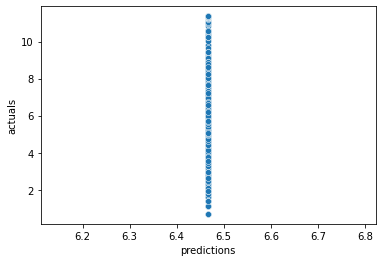

In [11]:
score, errors_base = mh.evaluate_predictions(preds = np.repeat(mean_pred, xval_.shape[0]), actuals = yval)

Now this is the basic prediction we want to beat. Let's see how many columns are required to do that.

## One Column Prediction

input data has 729296 rows
Subsetting Columns
output data has 546972 + 182324 rows
0.3897546655910137 0.3913840853845332
RMSE: 0.6197387781986154, r2: 0.3913840853845332, MAPE: 0.07553068218037742, MAE: 0.4506768601056615, RMSLE : 0.09019637691419372
Performing CV
input data has 729296 rows
Subsetting Columns
CV Mean RMSE: 0.6205891399888674, Std: 0.0021753871147232326


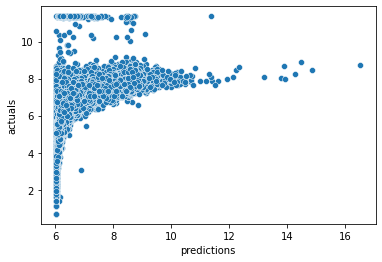

In [12]:
select_cols = ['trip_distance']
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(StandardScaler(), lin_reg()), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = False)

In [13]:
model_coefs = pd.DataFrame(model.named_steps.linearregression.coef_, index = model.feature_names_in_, columns = ['coef'])
model_coefs

,coef
trip_distance,0.496184


input data has 729296 rows
Subsetting Columns
output data has 546972 + 182324 rows
0.3897546655910137 0.3913840853845332
RMSE: 0.6197387781986154, r2: 0.3913840853845332, MAPE: 0.07553068218037742, MAE: 0.4506768601056615, RMSLE : 0.09019637691419372
Performing CV
input data has 729296 rows
Subsetting Columns
CV Mean RMSE: 0.6205891399888674, Std: 0.0021753871147232725


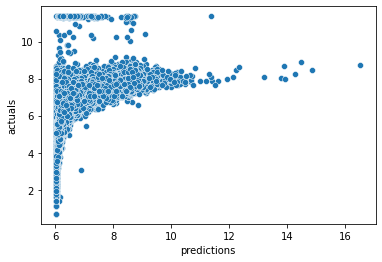

In [14]:
scores, model, pdf = mh.build_evaluate_model(model = lin_reg(), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = False)

In [15]:
model_coefs = pd.DataFrame(model.coef_, 
                           index = model.feature_names_in_, columns = ['coef'])
model_intercept = pd.DataFrame(model.intercept_, 
                           index = ['intercept'], columns = ['coef'])
model_coefs = pd.concat([model_coefs, model_intercept], axis = 0)

In [16]:

model_coefs

,coef
trip_distance,0.126159
intercept,6.033776


### Observations:
1. This is an improvement over the average prediction. But from the graphs, we can still see a lot of scope for improvement. Now, after the basic hygiene check, we can proceed with adding more columns.
2. Trip distance alone captures some of the variance in the data. The R2 we get is about 0.39, much better than the zero we had before. 

Good beginning. Now, add more features

### Inspect LinReg model - stastsmodels

In [17]:
x, y = dp.split_data(df, target = 'trip_duration', include_cols = select_cols)
x, _ = mh.scale_x(x,x)
x_sm = sm.add_constant(x, prepend=False)
mod = sm.OLS(y, x_sm)
res = mod.fit()
print(res.summary())

input data has 729296 rows
Subsetting Columns
                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                 4.666e+05
Date:                Fri, 03 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:57:50   Log-Likelihood:            -6.8689e+05
No. Observations:              729296   AIC:                         1.374e+06
Df Residuals:                  729294   BIC:                         1.374e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------


# Slightly Larger Model

## Linear Regression


input data has 729296 rows
Subsetting Columns
output data has 546972 + 182324 rows
0.5832949084452177 0.5837395362995105
RMSE: 0.5125303659720669, r2: 0.5837395362995105, MAPE: 0.06039875035952781, MAE: 0.3648354232469531, RMSLE : 0.07473661228246857
Performing CV
input data has 729296 rows
Subsetting Columns
CV Mean RMSE: 0.5129194431575824, Std: 0.0023570982317860745


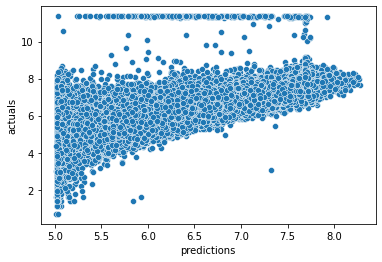

In [18]:
select_cols = ['log_distance', 'log_m_distance','passenger_count']
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(lin_reg()), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = True)

The CV RMSE has reduced. R2 has improved to 58%. Good signs.

### Inspect Linear Regression

In [27]:
x, y = dp.split_data(df, target = 'trip_duration', include_cols = select_cols)
x, _ = mh.scale_x(x,x)
x_sm = sm.add_constant(x, prepend=False)
mod = sm.OLS(y, x_sm)
res = mod.fit()
print(res.summary())

input data has 729296 rows
Subsetting Columns
                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                 1.734e+05
Date:                Fri, 03 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:01:35   Log-Likelihood:            -5.4397e+05
No. Observations:              729296   AIC:                         1.088e+06
Df Residuals:                  729289   BIC:                         1.088e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

## DTree

input data has 729296 rows
Subsetting Columns
output data has 546972 + 182324 rows
0.619756600450281 0.6056251718609224
RMSE: 0.49887485324303316, r2: 0.6056251718609224, MAPE: 0.058004434075676715, MAE: 0.3543611865471854, RMSLE : 0.07157447726913327
Performing CV
input data has 729296 rows
Subsetting Columns
CV Mean RMSE: 0.4983163288559238, Std: 0.0024940036894295155


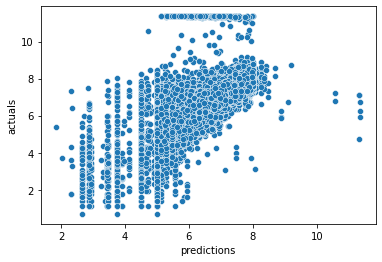

In [28]:
select_cols = ['log_distance', 'log_m_distance','passenger_count']
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(dtree(max_depth = 10)), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = False)

## Random Forest

input data has 729296 rows
Subsetting Columns
output data has 546972 + 182324 rows
0.6253923689674701 0.6120149743236207
RMSE: 0.4948168742283305, r2: 0.6120149743236207, MAPE: 0.057625536187913294, MAE: 0.3521204917203583, RMSLE : 0.07098069189975349
Performing CV
input data has 729296 rows
Subsetting Columns
CV Mean RMSE: 0.4942883778123486, Std: 0.002115223727868707


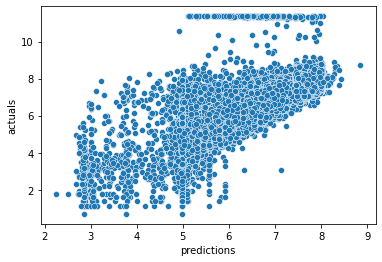

In [30]:

scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(rf(max_depth = 10, n_jobs = -1)), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = False)

From above, we get the following results:
With the three columns, 
linear_regression gets an RMSE of 
RMSE: 0.5125303659720669, r2: 0.5837395362995105, MAPE: 0.06039875035952781, MAE: 0.3648354232469531, RMSLE : 0.07473661228246857

Decision Tree gets:
RMSE: 0.49887485324303316, r2: 0.6056251718609224, MAPE: 0.058004434075676715, MAE: 0.3543611865471854, RMSLE : 0.07157447726913327

Random Forest gets:
RMSE: 0.4948168742283305, r2: 0.6120149743236207, MAPE: 0.057625536187913294, MAE: 0.3521204917203583, RMSLE : 0.07098069189975349

So, the tree based methods are slightly better than the linear method.

Now, we add the pickup DOW and Time of Day variables to see improvement.

# Slightly Larger Still

input data has 729296 rows
Subsetting Columns
output data has 546972 + 182324 rows
0.5877318789575405 0.588396840768399
RMSE: 0.5096550937383137, r2: 0.588396840768399, MAPE: 0.05993977825045737, MAE: 0.3620644320948011, RMSLE : 0.0743316520854894
Performing CV
input data has 729296 rows
Subsetting Columns
CV Mean RMSE: 0.5101484296898088, Std: 0.0022954000056518617


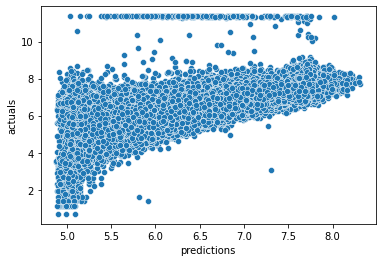

In [32]:
select_cols = ['log_distance', 'log_m_distance','passenger_count', 'vendor_id_1', 'pickup_dow', 'pickup_hour']
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(lin_reg()), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = True)

input data has 729296 rows
Subsetting Columns
output data has 546972 + 182324 rows
0.6694992712642949 0.6533905804955648
RMSE: 0.46768904780871495, r2: 0.6533905804955648, MAPE: 0.05260719980616977, MAE: 0.3200396540958519, RMSLE : 0.0674427567406765
Performing CV
input data has 729296 rows
Subsetting Columns
CV Mean RMSE: 0.4662925100935764, Std: 0.0024608588884511007


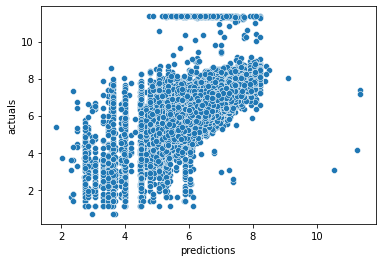

In [33]:
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(dtree(max_depth = 10)), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = False)

input data has 729296 rows
Subsetting Columns
output data has 546972 + 182324 rows
0.676321571131455 0.6610949262206496
RMSE: 0.4624620018173566, r2: 0.6610949262206496, MAPE: 0.05203531261247829, MAE: 0.31649806625877436, RMSLE : 0.06660941673819434
Performing CV
input data has 729296 rows
Subsetting Columns
CV Mean RMSE: 0.46103491399032775, Std: 0.0025580594425694274


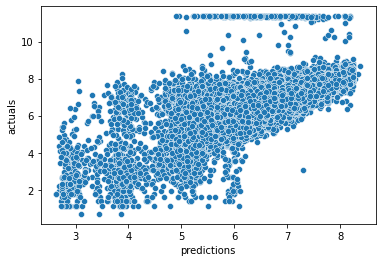

In [34]:
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(rf(max_depth = 10, n_jobs = -1)), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = False)

That's much better. We can see improving performance with adding information.

The RMSE has dropped to 46% with the random forest and added columns.

input data has 729296 rows
Subsetting Columns
output data has 546972 + 182324 rows
0.5990070155119049 0.6002113829318376
RMSE: 0.5022873395511134, r2: 0.6002113829318376, MAPE: 0.05874912525994141, MAE: 0.35434036717173556, RMSLE : 0.07350369811133747
Performing CV
input data has 729296 rows
Subsetting Columns
CV Mean RMSE: 0.50303732423169, Std: 0.0023406026726431484


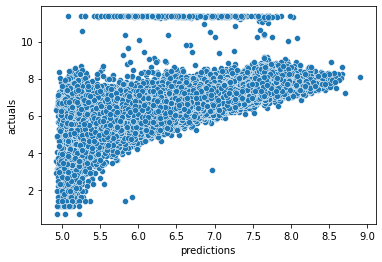

In [42]:
select_cols = ['log_distance', 'log_m_distance','passenger_count', 'vendor_id_1', 'pickup_dow', 'pickup_hour', 'total_distance', 'total_travel_time']
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(lin_reg()), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = True)

input data has 729296 rows
Subsetting Columns
output data has 546972 + 182324 rows
0.708982909238866 0.6897891803515193
RMSE: 0.4424513147791817, r2: 0.6897891803515193, MAPE: 0.048341875866237866, MAE: 0.29488657761776976, RMSLE : 0.06376931411193681
Performing CV
input data has 729296 rows
Subsetting Columns
CV Mean RMSE: 0.4413239739723139, Std: 0.003107772509793488


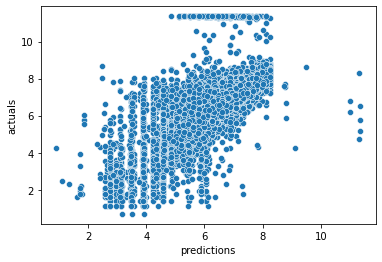

In [43]:
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(dtree(max_depth = 10)), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = False)

input data has 729296 rows
Subsetting Columns
output data has 546972 + 182324 rows
0.7182602649077895 0.701281503385951
RMSE: 0.4341782629732651, r2: 0.701281503385951, MAPE: 0.0474660920893461, MAE: 0.28933706917101937, RMSLE : 0.0625252938110247
Performing CV
input data has 729296 rows
Subsetting Columns
CV Mean RMSE: 0.43260072038782704, Std: 0.002875169909936512


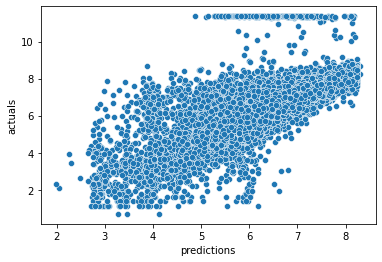

In [44]:
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(rf(max_depth = 10, n_jobs = -1)), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = False)

# Use All Columns

In [45]:
select_cols = [
        'vendor_id_1', 
    'passenger_count', 
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
    'pickup_dow', 'pickup_doy', 'pickup_week', 'pickup_hour', 
    'log_distance', 'log_m_distance', 
    'pickup_lat_bin', 'pickup_lon_bin', 'drop_lat_bin', 'drop_lon_bin',
    'total_distance', 'total_travel_time', 'number_of_steps',
       'cosine_distance', 'pickup_lat_bin_count', 'drop_lat_bin_count'
       
              ]

x,y = dp.split_data(df, target = 'trip_duration', include_cols=select_cols)


input data has 729296 rows
Subsetting Columns


input data has 729296 rows
Subsetting Columns
output data has 546972 + 182324 rows
0.6190248580179076 0.6193808675822524
RMSE: 0.4900973190952066, r2: 0.6193808675822524, MAPE: 0.05683457784415046, MAE: 0.34318692982334825, RMSLE : 0.07164062816903817
Performing CV
input data has 729296 rows
Subsetting Columns
CV Mean RMSE: 0.4904635295271357, Std: 0.0022172434490619797


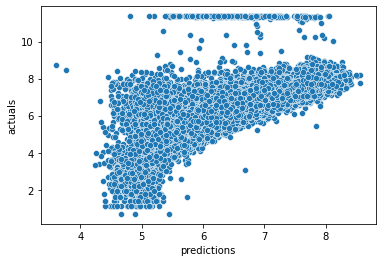

In [46]:
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(lin_reg()), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = True)

input data has 729296 rows
Subsetting Columns
output data has 546972 + 182324 rows
0.7239265894948685 0.7010350550662462
RMSE: 0.43435732862187704, r2: 0.7010350550662462, MAPE: 0.04681742481395836, MAE: 0.28553778306002764, RMSLE : 0.06267716914344594
Performing CV
input data has 729296 rows
Subsetting Columns
CV Mean RMSE: 0.43318654422027736, Std: 0.0026017302156152826


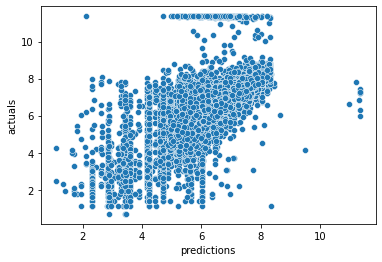

In [48]:
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(dtree(max_depth = 10)), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = False)

input data has 729296 rows
Subsetting Columns
output data has 546972 + 182324 rows
0.7376076128971238 0.7175253819515335
RMSE: 0.42220826865192984, r2: 0.7175253819515335, MAPE: 0.0454988530599102, MAE: 0.27721202516962345, RMSLE : 0.06080245340918324
Performing CV
input data has 729296 rows
Subsetting Columns
CV Mean RMSE: 0.4199596130106088, Std: 0.002886534541281848


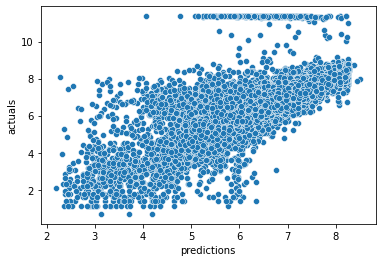

In [49]:
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(rf(max_depth = 10, n_jobs = -1)),
    df = df, 
    select_cols = select_cols,
    scale = False)

Adding a lot of columns helped bring the RF's CV RMSE down to ~41%, the R2 is ~72%.
This is good.

The next strategies for improving performance are Hyperparameter Grid Search and Recursive Feature Selection.
Then, we will add more features like location information (airport, mall etc.)

# Grid Search

In [50]:
from sklearn.model_selection import GridSearchCV

## Decision Tree

In [53]:
dt_params = {
    'max_depth' : [10,100],
#    'min_samples_split' : [2, 100, 500, 1000],
    'min_samples_leaf' : [1,10,100],
    'max_features' : [10,100],
#    'max_leaf_nodes' : [10,100]
}
grid_scv = GridSearchCV(estimator=dtree(), param_grid = dt_params, scoring = 'neg_mean_squared_log_error', verbose = 3)

In [54]:
grid_scv.fit(x, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_depth=10, max_features=10, min_samples_leaf=1;, score=-0.004 total time=   2.9s
[CV 2/5] END max_depth=10, max_features=10, min_samples_leaf=1;, score=-0.004 total time=   2.8s
[CV 3/5] END max_depth=10, max_features=10, min_samples_leaf=1;, score=-0.004 total time=   2.8s
[CV 4/5] END max_depth=10, max_features=10, min_samples_leaf=1;, score=-0.004 total time=   2.8s
[CV 5/5] END max_depth=10, max_features=10, min_samples_leaf=1;, score=-0.004 total time=   2.7s
[CV 1/5] END max_depth=10, max_features=10, min_samples_leaf=10;, score=-0.004 total time=   2.7s
[CV 2/5] END max_depth=10, max_features=10, min_samples_leaf=10;, score=-0.004 total time=   2.7s
[CV 3/5] END max_depth=10, max_features=10, min_samples_leaf=10;, score=-0.004 total time=   2.7s
[CV 4/5] END max_depth=10, max_features=10, min_samples_leaf=10;, score=-0.004 total time=   2.7s
[CV 5/5] END max_depth=10, max_features=10, min_samples_leaf=1

In [ ]:
grid_scv.best_estimator_

## Random Forest

In [ ]:
rf_params = {
    'max_depth' : [10,100],
#    'min_samples_split' : [2, 100, 500, 1000],
    'min_samples_leaf' : [1,10,100],
    'max_features' : [10,100],
#    'max_leaf_nodes' : [10,100]
}
grid_scv_rf = GridSearchCV(estimator=rf(), param_grid = rf_params, scoring = 'neg_mean_squared_log_error', verbose = 3)

# More Features

In [ ]:
select_cols = ['vendor_id','trip_distance', 'm_distance', 'log_distance', 'log_m_distance',
               'passenger_count', 'pickup_dow', 'pickup_doy',
               'time_of_day_morning_rush', 
               'time_of_day_evening_rush', 
               'total_distance', 'total_travel_time', 'number_of_steps', 
               'av_step_distance','av_step_time', 'cosine_distance',
               'pickup_latitude', 'pickup_longitude', 
               'dropoff_latitude', 'dropoff_longitude', 
               'pickup_lat_bin', 'pickup_lon_bin', 'drop_lat_bin', 'drop_lon_bin'
              ]



x = x_[select_cols]
xval = xval_[select_cols]
x_sc, xval_sc = scale_x(x,xval)
    
errors_lr = evaluate_linreg_model(select_cols)

# Ensemble Prediction

In [ ]:
preds_ens = pd.DataFrame()
preds_ens['lr_pred'] = preds_lr['predictions']
preds_ens['dt_pred'] = preds_dt['predictions']
preds_ens['avg_pred'] = (preds_lr['predictions']+preds_dt['predictions'])/2
preds_ens

In [ ]:
avg_pred = list(preds_ens['avg_pred'])
errors_ens, preds_ens = evaluate_predictions(avg_pred, yval)

In [ ]:
preds_ens['predictions_e'] = np.exp(preds_ens['predictions']) - 1
preds_ens['actuals_e'] = np.exp(preds_ens['actuals']) - 1
preds_ens['error_e'] = preds_ens['actuals_e'] - preds_ens['predictions_e']
preds_ens['p_error_e'] = (preds_ens['actuals_e'] - preds_ens['predictions_e'])/preds_ens['actuals_e']
preds_ens

In [ ]:
preds_n = list(preds_ens['predictions_e'])
actuals_n = preds_ens['actuals_e']
evaluate_predictions(preds_n, actuals_n)

In [ ]:
preds_ens.p_error_e.abs().mean()